In [1]:
import gzip
import pickle
import scipy
import numpy as np
import pandas as pd

from scipy import optimize
import matplotlib.pyplot as plt
import matrnn_distributional as dist

In [2]:
plt.rcParams['font.size'] = 8
plt.rcParams["font.family"] = "serif"

In [3]:
jobid = 'wtte'
d, w = 2, 64

In [4]:
finalstate_fname = 'finalstate_jobid' + str(jobid) + '_d' + str(d) + 'w' + str(w) + '.pkl'

In [5]:
finalstate = pickle.load(gzip.open(finalstate_fname, 'rb'))

In [6]:
mtest = pickle.load(gzip.open('mlocaltest.pkl', 'rb'))

In [7]:
def split(m):
    nobs, nseq, nvar = m.shape
    
    # indices at [1,2] are tte, unc 
    x = m[:, :, np.delete(np.arange(nvar), [1,2])]
    y = m[:, :, :4].reshape((nobs, nseq, 1, 4))
    y[y<0] = 0
    return x, y

In [8]:
xtest, ytest = split(mtest)

## Plot final scales and shapes...

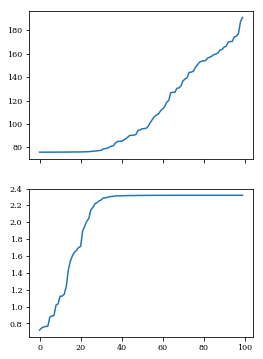

In [9]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(4,6))
ax[0].plot(np.sort(finalstate[:, 0]))
ax[1].plot(np.sort(finalstate[:, 1]))

plt.show()

In [10]:
tse, sc, sh = xtest[:, -1, 0], finalstate[:, 0], finalstate[:, 1]

In [11]:
# wtte is equivalent to tse==0
tse = np.zeros(sc.shape)

## Load RUL

In [12]:
rul = pickle.load(gzip.open('rul.pkl', 'rb'))

## Density vs True RUL

In [13]:
dfall = pd.DataFrame({'tse': tse,
                      'sc': sc,
                      'sh': sh,
                      'rul': rul})

In [14]:
dfall = dfall.sort_values('rul')
dfall = dfall.reset_index()

In [15]:
print (dfall.head(5))

   index  rul         sc        sh  tse
0     33  7.0  75.958580  0.874548  0.0
1     67  8.0  75.946671  0.764298  0.0
2     30  8.0  75.947052  0.758905  0.0
3     80  8.0  75.945076  0.746861  0.0
4     81  9.0  75.973061  1.031588  0.0


In [16]:
xvals = dfall['rul']

In [17]:
minx, maxx = .8*min(xvals), 1.2*max(xvals)

In [18]:
print (minx, maxx)

5.6000000000000005 174.0


In [19]:
nxplot = 1000

In [20]:
xvals = np.linspace(minx, maxx, nxplot)

In [21]:
densem = np.zeros((len(dfall), len(xvals)))

In [22]:
idex = 0
for index, row in dfall.iterrows():
    tsetemp = row['tse']
    sctemp = row['sc']
    shtemp = row['sh']
    #print ('tse:', tsetemp, 'sc:', sctemp, 'sh:', shtemp)
    densetemp = np.exp(dist.logdiscrete(tsetemp, xvals, sctemp, shtemp))
    densetemp = densetemp - np.min(densetemp)
    densetemp = densetemp / np.max(densetemp)
    densem[idex,:] = densetemp
    idex += 1

In [23]:
densem.shape

(100, 1000)

In [24]:
densem = densem / np.max(densem)

In [25]:
csfont = {'fontname':'Times New Roman',
          'size': 8}

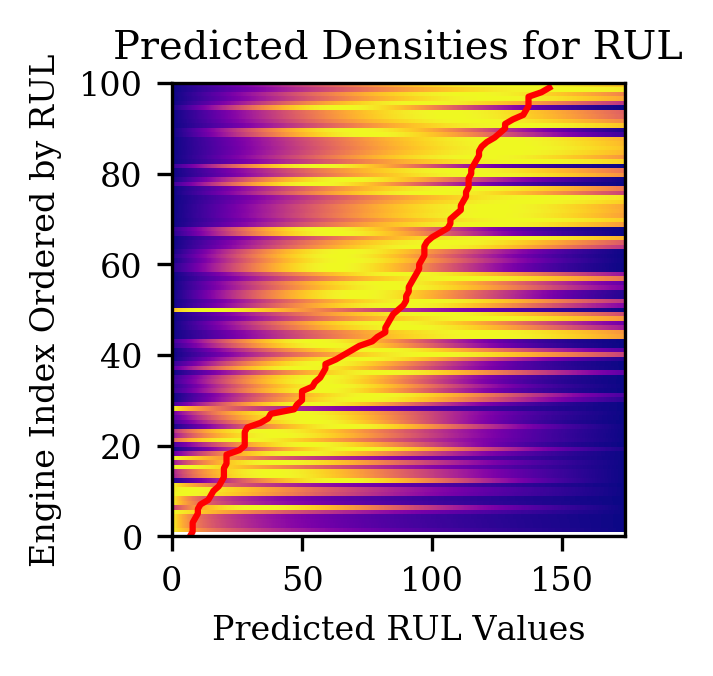

In [26]:
plt.figure(figsize = (2, 2), dpi = 300)

plt.imshow(densem, cmap = 'plasma', 
           origin = 'lower', interpolation = 'none', 
           aspect = maxx/len(dfall), extent = [0, maxx, 1, len(dfall)])
plt.title('Predicted Densities for RUL')
plt.xlabel('Predicted RUL Values')
plt.ylabel('Engine Index Ordered by RUL')
plt.plot(dfall['rul'], np.arange(len(dfall)), color = 'red')
plt.xlim((0, maxx))
plt.ylim((0, len(dfall)))
plt.show()

## Loss Function

In [27]:
def lossfn(d):
    a1, a2 = 13, 10
    return (np.exp(-d/a1)-1)*(d<0)+(np.exp(d/a2)-1)*(d>0)

## Mode as RUL-Est

In [28]:
metric_mode = dist.quantile(tse, .5, sc, sh)

In [29]:
metric_mode[:10]

array([159.97119776, 139.77945456,  69.20383284,  94.9213916 ,
        92.76279267, 101.17629491,  96.35254358,  72.72228155,
       136.04596749,  73.66185029])

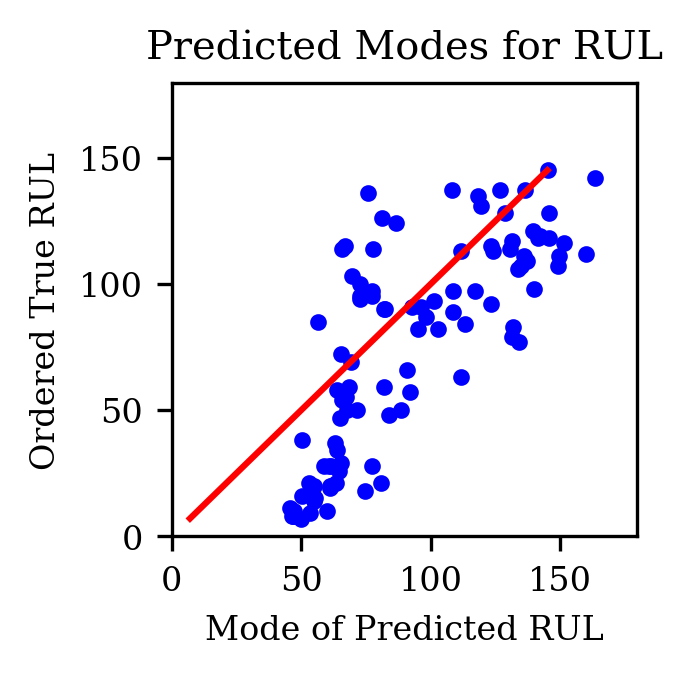

In [30]:
metric = metric_mode

plt.figure(figsize = (2, 2), dpi = 300)
plt.scatter(metric, rul, 
            marker = '.', color = 'b')
xmax = max(metric)
ymax = max(rul)
pltmax = 1.1*max(xmax, ymax)
plt.plot(dfall['rul'], dfall['rul'], color = 'red')

plt.title('Predicted Modes for RUL')
plt.xlabel('Mode of Predicted RUL')
plt.ylabel('Ordered True RUL')
plt.xlim(0, pltmax)
plt.ylim(0, pltmax)

plt.show()

In [31]:
min(metric_mode - rul), max(metric_mode - rul)

(-60.310485997991776, 59.710504665354776)

In [32]:
q = [0, 25, 50, 75, 100]
np.percentile(metric_mode - rul, q)

array([-60.310486  ,   0.45296636,  22.26888294,  37.42742185,
        59.71050467])

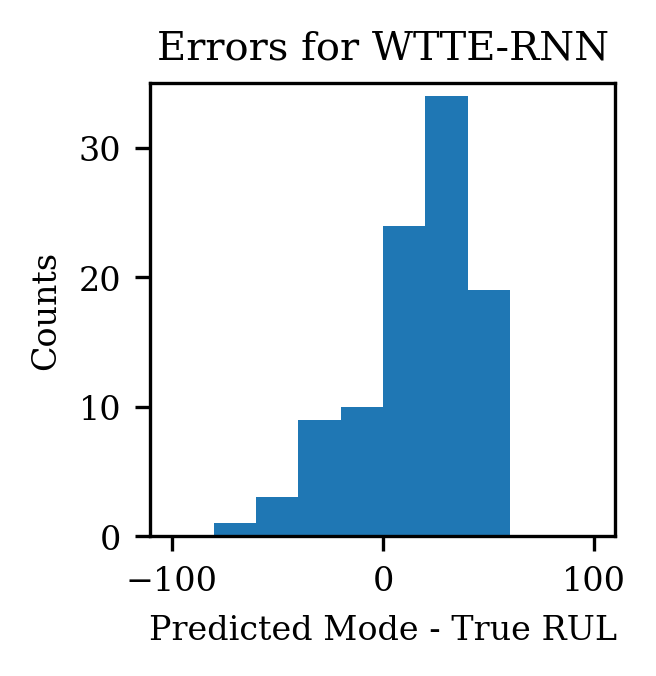

In [33]:
plt.figure(figsize = (2, 2), dpi = 300)
plt.hist(metric_mode - rul, range = (-100, 100))
plt.ylim((0, 35))
plt.title('Errors for WTTE-RNN')
plt.xlabel('Predicted Mode - True RUL')
plt.ylabel('Counts')
plt.show()

In [34]:
mloss = np.average(lossfn(metric_mode - rul))
print ('mloss:', mloss)

mloss: 36.84642046803706


In [35]:
mse = np.average(np.power(metric_mode - rul, 2))
print ('mse:', mse)

mse: 992.0556673295786


In [36]:
rmse = np.sqrt(mse)
print ('rmse:', rmse)

rmse: 31.49691520339061


## Expected Loss Minimizer as RUL-Est

In [37]:
def wbsample(tse, sc, sh, n=1000):
    u = np.random.sample(n)
    return dist.quantile(tse, u, sc, sh)

In [38]:
def loss(x, wbsamplearr):
    d = x-wbsamplearr
    losstemp = lossfn(d)
    return np.average(losstemp)

In [39]:
ntest = xtest.shape[0]
metric_lossmin = np.zeros(ntest)
for i in range(ntest):
    wbsamplearr = wbsample(tse[i], sc[i], sh[i])
    metric_lossmin[i] = optimize.minimize(lambda x: loss(x, wbsamplearr), 1).x

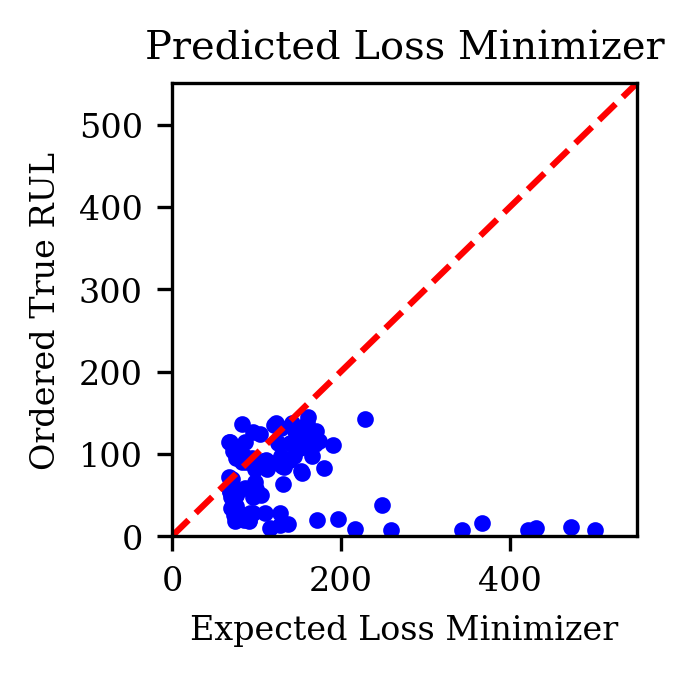

In [40]:
metric = metric_lossmin

plt.figure(figsize = (2, 2), dpi = 300)
plt.scatter(metric, rul, 
            marker = '.', color = 'b')
xmax = max(metric)
ymax = max(rul)
pltmax = 1.1*max(xmax, ymax)
plt.plot([0, pltmax], 
         [0, pltmax], 
         linestyle = '--', color = 'r')

plt.title('Predicted Loss Minimizer')
plt.xlabel('Expected Loss Minimizer')
plt.ylabel('Ordered True RUL')
plt.xlim(0, pltmax)
plt.ylim(0, pltmax)

plt.show()

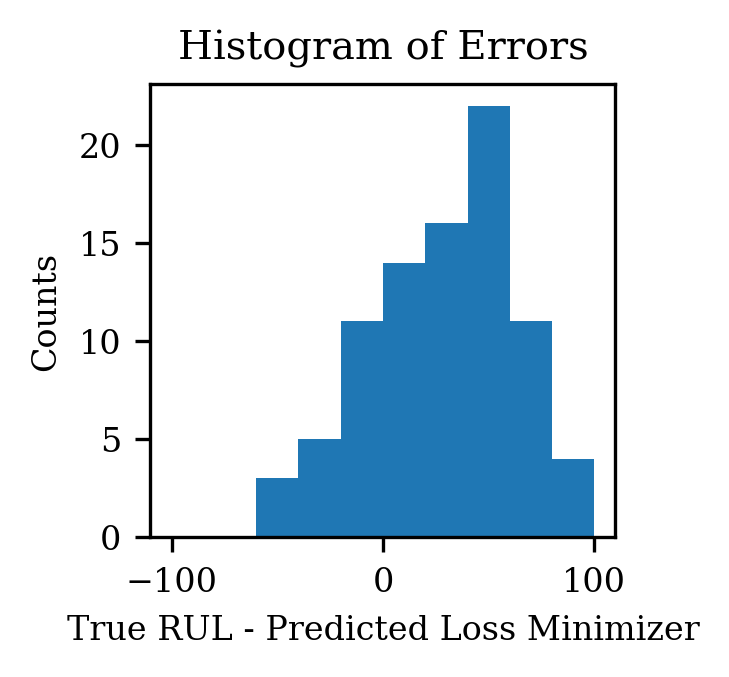

In [41]:
plt.figure(figsize = (2, 2), dpi = 300)
plt.hist(metric_lossmin - rul, range = (-100,100))
plt.title('Histogram of Errors')
plt.xlabel('True RUL - Predicted Loss Minimizer')
plt.ylabel('Counts')
plt.show()

In [42]:
mloss = np.average(lossfn(metric_lossmin - rul))
print ('mloss:', mloss)

mloss: 2.549635755698982e+19


In [43]:
mse = np.average(np.power(metric_lossmin - rul, 2))
print ('mse:', mse)

mse: 14535.10416207944


In [44]:
rmse = np.sqrt(mse)
print ('rmse:', rmse)

rmse: 120.56161977212915
